In [81]:
import warnings
import copy

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Functions import pmfg
import seaborn as sns
import networkx as nx


warnings.filterwarnings('ignore')
%matplotlib inline


df = pd.read_excel("Credit risk exposures and exposures to sovereigns a.xlsx", 
                   header=1, index_col=0)
df = df.iloc[:, 0:8]
df = df.drop("4. Total retail", axis = 1)
df.columns = ["1_Sov", "2_Fin", "3_Corp", "4-1_Ret_Res", "4-2_Ret_Rev", "4-3_Ret_SME", "5_CRE"]

bank_names_df = pd.read_csv("BankCodes.csv", index_col=0).iloc[:, 0]

sd_df = pd.read_excel("EU_SOV_Debt_Bank_Net_2011.xlsx", header=0, index_col=0).T
sd_df.columns = sd_df.columns.rename("SD_Name")
sd_names = [sd.encode('ascii', 'ignore') for sd in sd_df.columns]
sd_names_prefix = ["1_Sov_" + sd for sd in sd_names]

cap_df = pd.read_excel("Tier-1 CRs 2010.xlsx", 
                       header=2, index_col=1).iloc[:, 1].to_frame("Capital")

df = pd.merge(sd_df, df, left_index=True, right_index=True).rename(columns={"1_Sov":"1b_Sov"})
df = pd.merge(df, cap_df, left_index=True, right_index=True).applymap(np.float)
df.loc[:, "1b_Sov"] = df.loc[:, "1b_Sov"] - df.loc[:, sd_names].apply(np.sum, axis=1)
df.loc[:, "1b_Sov"] = np.maximum(df.loc[:, "1b_Sov"], 0.)

df = pd.merge(df, bank_names_df.to_frame("Name"), left_index=True, right_index=True)

In [36]:
def Overlap(x1, x2):
    # Normalized dot product between two pd.Series
    return x1.dot(x2) / np.sqrt(x1.dot(x1) * x2.dot(x2))


def getRiskWeights(minmax):
    # Initialize dictionaries
    if minmax == "min":
        return {"1": 0.002, "1b": 0.002, "2": 0.5, "3": 0.7, 
                "4-1": 0.4, "4-2": 0.8, "4-3": 1, "5": 1}
    elif minmax == "max":
        return {"1": 0.1, "1b": 0.1, "2": 1, "3": 1.3, 
                "4-1": 0.8, "4-2": 1.2, "4-3": 1.3, "5": 2}
    else:
        # In case of input error, return minimum weights.
        return {"1": 0.002, "1b": 0.002, "2": 0.5, "3": 0.7, 
                "4-1": 0.4, "4-2": 0.8, "4-3": 1, "5": 1}

    
def BankSnap(enhancement, banks, assets):
    # Enhancement is the indicator if we allow crisis to affect risk factors of 
    #other asset classes
    if enhancement == False:
        return [[bank, banks[bank].getCapital(), banks[bank].getRWA(assets)]
                for bank in banks]
    else:
        banksnap = []
        for bank in banks:
            sd_names = [assets[asset].getName() for asset in assets
                        if assets[asset].getAssetClass() == '1']
            
            df = pd.DataFrame([[asset, assets[asset].getCrisisLevel()] 
                               for asset in sd_names], 
                              columns=["asset", "crisislevel"]).set_index("asset")

            crisislevel = banks[bank].getGeoStructure(assets).dot(df)
            for asset in list(set([asset for asset in assets])-set(sd_names)):
                obj = assets[asset]
                obj.riskweight = crisislevel*obj.riskweight

            rwa = banks[bank].getRWA(assets)

            for asset in list(set([asset for asset in assets])-set(sd_names)):
                obj = assets[asset]
                obj.riskweight = obj.staticriskweight

            banksnap.append([bank, banks[bank].getCapital(), rwa])

        return banksnap
    

def AssetSnap(banks, assets):
    sd_names = [assets[asset].getName() for asset in assets
                if assets[asset].getAssetClass() == '1']    
    
    return [[asset, assets[asset].getValue(), 
             assets[asset].riskweight] for asset in sd_names]
     
    
# Function to select from DataFrame
def dfSelecter(df, rows=None, columns=None):
    if rows == None:
        if columns == None:
            return df.copy()
        else:
            try:
                return df.loc[:, columns]
            except KeyError:
                print "Name Error in column."
    else:
        if columns == None:
            try:
                return df.loc[rows]
            except KeyError:
                print "Name Error in row."
        else:
            try:
                return df.loc[rows, columns]
            except KeyError:
                try:
                    df.loc[:, columns]
                except KeyError:
                    print "Name Error in column."
                try:
                    df.loc[rows]
                except KeyError:
                    print "Name Error in row."


        
# Functions from the model        
def P(x):
    return np.minimum(0.1 + 0.9*x, 1)

def Q(x):
    return 1. - 2**(-x/100.)

In [83]:
# Classes in the project:
# World -- instance is the current dataset
# Bank -- instances are individual banks
# Asset, subclasses SovereignDebt and PrivateDebt 
#   -- instances are sovereign debts and other kinds of investments
# Snapshot -- instances are bank and asset data at a given time


class World(object):
    # Encoding the dataset to be used with year-info
    def __init__(self, structure):
        self._structure = structure
    
    # All investments etc.
    def getAll(self, bank=None, asset=None):
        try:
            df = self._structure.drop(["Capital", "Name"], axis=1)
        except:
            df = self._structure
        return dfSelecter(df, bank, asset)
    
    # Only Soverein Debt investments
    def getSD(self, bank=None, asset=None):
        sd_names = [sd.encode('ascii', 'ignore') for sd in sd_df.columns]
        return dfSelecter(self._structure.loc[:, sd_names], bank, asset)
    
    # Read Capital information
    def getCapital(self, bank=None):    
        if bank == None:
            return dfSelecter(self._structure, columns="Capital")
        else:
            return dfSelecter(self._structure, rows=bank, columns="Capital")
        
    def getName(self, bank=None):    
        if bank == None:
            return dfSelecter(self._structure, columns="Name")
        else:
            return dfSelecter(self._structure, rows=bank, columns="Name")

In [86]:
class Bank(object):
    # Initialize with name, country, holdings and capital ratio (since this is what we know)
    # When the stress test scenario is initialized, the capital is updated using the ratio 
    # and the RWA.
    
    def __init__(self, bankid, name, country, holdings, capital):
        self._bankid = bankid
        self._name = name
        self._country = country
        self._holdings = holdings
        self._capital = capital

    
    # Name of the bank
    def getName(self):
        return self._name

    def setName(self, n):
        self._name = n
        
    name = property(getName, setName)

    
    # EBA Bank ID
    def getBankID(self):
        return self._bankid
    
    
    # Country in which the bank is headquartered
    def getCountry(self):
        return self._country
    
    
    # Overview of holdings of a certain bank, in absolute values
    def getHoldings(self, assets, sd_only=False):
        df = self._holdings.to_frame("value")
        # Store asset class in frame for easy filtering
        df.loc[:, "class"] = [assets[asset].getAssetClass() for asset in df.index.values]
        if sd_only:
            return df.loc[(df["class"] == '1') | (df["class"] == '1b')]
        else:
            return df
        
#     def getHoldings(self, sd_only=False):
#     df = self._holdings
#     if sd_only:
#         return df.loc[(df["class"] == '1') | (df["class"] == '1b'), "value"]
#     else:
#         return df.loc[:, "value"]

    
    # Capital of a bank, in absolute values
    # WARNING: Due to the structure of the available data, initialization begins with ratio!
    def getCapital(self):
        return self._capital
    
    def setCapital(self, c):
        self._capital = c
        
    capital = property(getCapital, setCapital)
    
        
    # Calculate Risk-Weighted Asset value
    def getRWA(self, assets):
        holdings = self.getHoldings(assets, sd_only=False).loc[:, "value"]
        return np.sum([holdings.loc[asset]*assets[asset].riskweight
                       for asset in holdings.index])
    
    # Overview of investment structure of Sovereign Debt to infer a banks geographical 
    # investment strategy for other assets
    def getGeoStructure(self, assets):
        df = self.getHoldings(assets)
        df = df.loc[df["class"]=='1', "value"]
        return df/np.sum(df)
    
    # Calculate initial exposure to the shock: How many per-cent of a banks sovereign debt
    # is from countries that we shock
    def getInitialExposure(self, assets):
        df = self.getHoldings()
        sd_names = [assets[asset].getName() for asset in assets
                    if assets[asset].getAssetClass() == '1']
        
        return np.sum(df.loc[[assets[asset].isShocked() 
                              for asset in [assets[asset]]], "value"]) \
                / np.sum(df.loc[sd_names, "value"])
            
        
    
    # Function to calculate investment with another bank overlap via dot-product
    def getOverlap(self, other, sd_only=False):
        return Overlap(self.getHoldings(sd_only=sd_only).loc[:, "value"], 
                       other.getHoldings(sd_only=sd_only).loc[:, "value"])
    
    def __str__(self):
        return '{}, from {}'.format(self.name, self.country)

    

In [85]:
class Asset(object):
    # Initialize with asset class, name of asset, value, who holds it, but w/o risk weights
    def __init__(self, asset_class, name, value, holders, riskweight=None):
        self._asset_class = asset_class
        self._name = name
        self._value = value
        self._marketvalue = value
        self._holders = holders
        self._riskweight = riskweight
        self._staticriskweight = riskweight
        
        
    # Name of asset, in case of SD 2-letter country code
    def getName(self):
        return self._name
    
    
    # Asset class, including sovereign debt, finance, commercial, retail and real estate.
    def getAssetClass(self):
        return self._asset_class
    
    
    # Total value of asset combining holdings of all banks
    def getValue(self):
        return self._value
    
    
    # Overview over which banks hold how much, in percent
    def getHolders(self):
        return self._holders
    
    
    # Output risk weight or risk factor of asset at current moment
    def getRiskWeight(self):
        return self._riskweight
    
    # Function to update risk factor in crisis propagation
    def setRiskWeight(self, r):
        self._riskweight = r
        
    riskweight = property(getRiskWeight, setRiskWeight)

    
    # staticriskweight is the risk factor which was used to initialize asset
    def getStaticRiskWeight(self):
        return self._staticriskweight
        
    def setStaticRiskWeight(self, r):
        self._staticriskweight = r
        
    staticriskweight = property(getStaticRiskWeight, setStaticRiskWeight)    
    
    # Overlap in holders with another asset, in absolute numbers
    def getOverlap(self, other):
        return overlap(self.getValue()*self.getHolders(), 
                       other.getValue()*other.getHolders())
    
    def __str__(self):
        return '{}, class {}, value of {}, risk-weight {}'.format(self._name, 
                self._asset_class, np.round(self._value, 0), self.riskweight)
        
        
class SovereignDebt(Asset):
    # Subclass of Asset, can be shocked and is an indicator for crisis level of a country
    def __init__(self, name, value, holders, riskweight=None, shocked=False):
        Asset.__init__(self, "1", name, value, holders, riskweight=None)
        self._shocked = shocked
    
    
    def getCountry(self):
        return self._country
    
    
    def isShocked(self):
        return self._shocked
    
    
    def shock(self, s):
        self._shocked = s
        
        
    # Measures how much risk factor has risen above original value, capped at +50%
    # Used to enhance spread, since a bank invested in SD of country A is likely also to
    # be invested in retail business there, and we want to adjust that risk weight, too.
    def getCrisisLevel(self):
        return np.minimum(np.square(self._riskweight/self._staticriskweight), 1.5)
    
            
        
class PrivateDebt(Asset):
    # Subclass of Asset, cannot be shocked for now and will remain at same weight.
    def __init__(self,asset_class, name, value, holders, riskweight=None):
        Asset.__init__(self, asset_class, name, value, holders, riskweight=None)
        
        
    def isShocked(self):
        return False
    
    
    def getCrisisLevel(self):
        return 1.
    
    

class Snapshot(object):
    # Class to keep track of crisis progression; records DF for banks and assets
    def __init__(self, time):
        self._time = time
        self._banks = None
        self._assets = None
        
        
    def getTime(self):
        return self._time
    
    
    def getBankSnap(self):
        return self._banks
    
    def setBankSnap(self, data):
        df = pd.DataFrame(data=data, 
                          columns=["bank", "C", "W"]).set_index("bank").sort_index()
        df.loc[:, "R"] = df.loc[:, "C"]/df.loc[:, "W"]
        self._banks = df
        
    banks = property(getBankSnap, setBankSnap)
        
        
    def getAssetSnap(self):
        return self._assets
    
    def setAssetSnap(self, data):
        df = pd.DataFrame(data=data, 
                          columns=["asset", "value", "weight"])
        df = df.set_index("asset").sort_index()
        self._assets = df

    assets = property(getAssetSnap, setAssetSnap)

In [91]:
def RiskUpdate(time, banks, assets, timesteps, world):
    # Update risk factors acc. to model
    # Q(D_s) is the spreading parameter, assumed homogeneous here. 
    delta_R = timesteps[time-0].getBankSnap().loc[:, "R"] \
                / timesteps[time-2].getBankSnap().loc[:, "R"]
    omega_s = 1 - Q(100) + Q(100)*(world.getSD().T.dot(P(delta_R)) \
                                    / (world.getSD().apply(np.sum)))

    for asset in omega_s.index:
        obj = assets[asset]
        obj.riskweight = obj.riskweight/omega_s.loc[asset]


def InitScenario(minmax, world, banks, assets):
    # Delete any old initializations
    DelScenario(world, banks, assets)
    # Load appropriate risk factor dictionary
    riskweights = getRiskWeights(minmax)
    # Initialize risk factors for assets
    for asset in assets:
        obj = assets[asset]
        obj.riskweight = riskweights[obj.getAssetClass()]
        obj.staticriskweight = riskweights[obj.getAssetClass()]

    # Calculate capital from information from data
    for bank in banks:
        obj = banks[bank]
        obj.setCapital(obj.getCapital()*obj.getRWA(assets))

    return True, banks, assets


def DelScenario(world, banks, assets):
    # Remove any initializations
    for asset in world.getAll().columns:
        obj = assets[asset]
        obj.setRiskWeight(None)
    for bank in banks:
        obj = banks[bank]
        obj.setCapital(world.getCapital(bank=bank))

    return False


def Shock(ScenarioSet, shocklist, shockfactor, banks, assets):
    # Shock the appropriate sovereign debts
    # Increase their risk weight and set a flag.
    if ScenarioSet:
        for asset in assets:
            if asset in shocklist:
                obj = assets[asset]
                obj.riskweight= shockfactor*obj.riskweight
                obj.shock(True)
    else:
        print "Error. Set Scenario first."

In [211]:
def RunSimulation(world, shock_list, shockfactor, enhancement, T_max):
    
    timesteps = {}
    ScenarioSet = False

    # Initialize banks and assets

    banks = {}
    for bank in world.getAll().index.values:
        banks[bank] = Bank(bank,
                           world.getName(bank=bank),
                           bank[0:2], 
                           world.getAll(bank=bank), 
                           world.getCapital(bank=bank))

    assets = {}
    for asset in world.getAll().columns.values: 
        if asset in world.getSD().columns.values:
            assets[asset] = SovereignDebt(asset, 
                                          np.sum(world.getSD(asset=asset)), 
                                          world.getSD(asset=asset) \
                                            / np.sum(world.getSD(asset=asset)),
                                          None, 
                                          False)
        else:
            asset_class = asset[:asset.find("_")]
            assets[asset] = PrivateDebt(asset_class, 
                                        asset, 
                                        np.sum(world.getAll(asset=asset)), 
                                        world.getAll(asset=asset) \
                                          / np.sum(world.getAll(asset=asset)),
                                        None)

    # Run loop
    for time in range(0,T_max):
        # Initialize a new snapshot
        timesteps[time] = Snapshot(time)

        if time == 0:
            # Initialize simulation
            ScenarioSet, banks, assets = InitScenario("min", world, banks, assets)
            # Record initial values for banks and assets
            timesteps[time].banks  = BankSnap(enhancement, banks, assets)
            timesteps[time].assets = AssetSnap(banks, assets)

        elif time == 1:
            # Shock sovereign debts of countries w/ certain strengh
            Shock(ScenarioSet, shock_list, shockfactor, banks, assets)
            # Record resulting values for banks and assets
            timesteps[time].banks  = BankSnap(enhancement, banks, assets)
            timesteps[time].assets = AssetSnap(banks, assets)

        elif np.mod(time,2) == 0:
            # In even steps we update the risk values according to the model.
            # In this case we want to record bank values (because they depend on RWA,
            # which depends on risk weights) before we engage.
            timesteps[time].banks  = BankSnap(enhancement, banks, assets)
            RiskUpdate(time, banks, assets, timesteps, world)
            timesteps[time].assets = AssetSnap(banks, assets)

        else:
            # Update bank values, do nothing to assets.
            timesteps[time].banks  = BankSnap(enhancement, banks, assets)
            timesteps[time].assets = AssetSnap(banks, assets)
       

    # Separation between even and odd seems unnecessary, but allows for 
    # easier modifaction
         
    return banks, assets, timesteps

In [137]:
T_max = 20
banks, assets, timesteps = RunSimulation(World(df), ["GR", "CY"], 100, True, T_max)

In [124]:
banks_df = pd.concat([timesteps[0].getBankSnap().loc[:, "R"], 
                      timesteps[1].getBankSnap().loc[:, "R"]], axis=1)
for t in range(2,T_max,1):
    banks_df = pd.concat([banks_df, timesteps[t].getBankSnap().loc[:, "R"]], axis=1)
    
banks_df.columns = [str(i) for i in range(0,T_max)]
#banks_df.T.plot(figsize=(8,18), legend=False)

In [163]:
print "Initial"
print timesteps[0].getAssetSnap().head()
for t in range(2,np.minimum(T_max,10),1):
    print "\n", t
    print timesteps[t].getAssetSnap().head()

Initial
              value  weight
asset                      
AT     42420.496007   0.002
BE     90471.633340   0.002
BG      1845.151329   0.002
CY      2347.477392   0.002
CZ     25635.981796   0.002

2
              value    weight
asset                        
AT     42420.496007  0.002009
BE     90471.633340  0.002009
BG      1845.151329  0.002071
CY      2347.477392  0.224449
CZ     25635.981796  0.002008

3
              value    weight
asset                        
AT     42420.496007  0.002009
BE     90471.633340  0.002009
BG      1845.151329  0.002071
CY      2347.477392  0.224449
CZ     25635.981796  0.002008

4
              value    weight
asset                        
AT     42420.496007  0.002017
BE     90471.633340  0.002016
BG      1845.151329  0.002080
CY      2347.477392  0.225008
CZ     25635.981796  0.002017

5
              value    weight
asset                        
AT     42420.496007  0.002017
BE     90471.633340  0.002016
BG      1845.151329  0.002080
CY  

In [106]:
print "Initial"
print timesteps[0].getBankSnap().head()
print "\n Shock of SDs"
print timesteps[1].getBankSnap().head()

for t in range(3,np.minimum(T_max,10),2):
    print "\n", t
    print timesteps[t].getBankSnap().head()

Initial
                  C              W      R
bank                                     
AT001   9946.277940  114325.033788  0.087
AT002   6316.739320   77984.436055  0.081
AT003   1526.484415   23851.318992  0.064
BE004  23316.612348  192699.275600  0.121
BE005  11141.775009  106112.142942  0.105

 Shock of SDs
                  C              W         R
bank                                        
AT001   9946.277940  116867.606753  0.085107
AT002   6316.739320   79442.239804  0.079514
AT003   1526.484415   24075.050265  0.063405
BE004  23316.612348  219217.835523  0.106363
BE005  11141.775009  109186.985548  0.102043

3
                  C              W         R
bank                                        
AT001   9946.277940  125772.003029  0.079082
AT002   6316.739320   86451.465643  0.073067
AT003   1526.484415   26307.991019  0.058024
BE004  23316.612348  232035.871460  0.100487
BE005  11141.775009  118389.111528  0.094111

5
                  C              W         R
ba

In [112]:
world = World(df)
normalized_df = world.getSD()
norm_col = normalized_df.apply(np.sum, axis=0) / np.sum(normalized_df.apply(np.sum, axis=0))
norm_row = normalized_df.apply(np.sum, axis=1) / np.sum(normalized_df.apply(np.sum, axis=1))
# fig, ax = plt.subplots(figsize=(15,9))
# sns.heatmap(pd.DataFrame(np.outer(norm_col, norm_row),
#                          columns=normalized_df.index, 
#                          index=normalized_df.columns), ax=ax)
normalized_df = pd.DataFrame(np.outer(norm_row, norm_col),
                             columns=normalized_df.columns, 
                             index=normalized_df.index)
normalized_df = np.sum(np.sum(World(df).getSD())) * normalized_df
normalized_df = pd.concat([normalized_df, 
                           world.getAll().iloc[:, -7:],
                           world.getCapital(),
                           world.getName()],
                          axis=1)

In [125]:
banks_norm, \
assets_norm, \
timesteps_norm = RunSimulation(World(normalized_df), ["GR", "CY"], 100, True, T_max)

In [126]:
banks_norm_df = pd.concat([timesteps_norm[0].getBankSnap().loc[:, "R"], 
                           timesteps_norm[1].getBankSnap().loc[:, "R"]], axis=1)
for t in range(2,T_max,1):
    banks_norm_df = pd.concat([banks_norm_df, 
                               timesteps_norm[t].getBankSnap().loc[:, "R"]], axis=1)
    
banks_norm_df.columns = [str(ceil(i/2.)) for i in range(0,T_max,2)]
#banks_norm_df.T.plot(figsize=(8,18), legend=False)

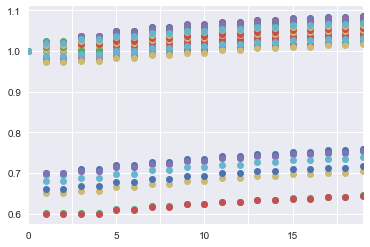

In [132]:
banks_df.div(banks_norm_df).T.plot(legend=False, style='o')

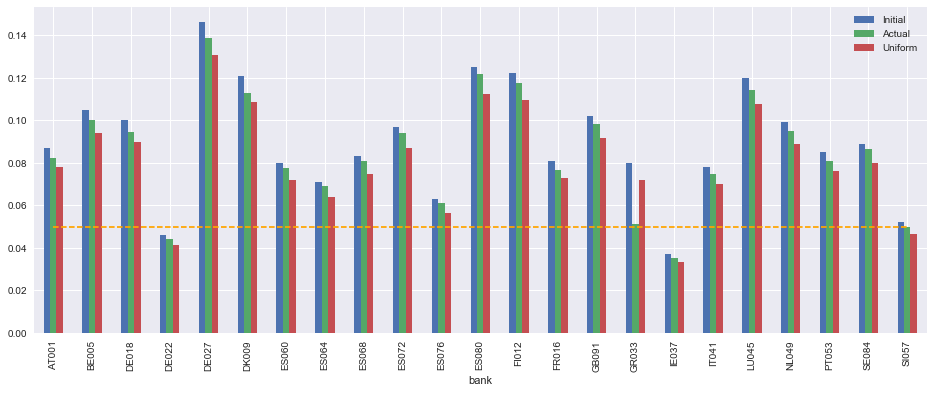

In [161]:
fig, ax = plt.subplots()
plot_df = pd.concat([timesteps[0].getBankSnap().loc[:, "R"].iloc[0::4], 
                     timesteps[T_max-1].getBankSnap().loc[:, "R"].iloc[0::4],
                     timesteps_norm[T_max-1].getBankSnap().loc[:, "R"].iloc[0::4]], axis=1)
plot_df.columns = ["Initial", "Actual", "Uniform"]
plot_df.plot(kind='bar', ax=ax, figsize=(16,6))
plt.plot([0.05 for _ in plot_df.index], color='orange', linestyle='--')

In [210]:
def GenerateFigures(world_1, world_2, shock_list, shockfactor, enhancement, T_max):
    if type(shock_list) == str:
        shock_list = [shock_list]
    if T_max <= 2:
        print "Set T_max to at least 3"
        T_max = 3

    banks_1, assets_1, timesteps_1 =\
        RunSimulation(world_1, shock_list, shockfactor, enhancement, T_max)
    banks_1_df = pd.concat([timesteps_1[0].getBankSnap().loc[:, "R"], 
                            timesteps_1[1].getBankSnap().loc[:, "R"]], axis=1)
    assets_1_df = pd.concat([timesteps_1[0].getAssetSnap().loc[:, "weight"], 
                             timesteps_1[1].getAssetSnap().loc[:, "weight"]], axis=1)
    for t in range(2,T_max):
        banks_1_df = pd.concat([banks_1_df,
                                timesteps_1[t].getBankSnap().loc[:, "R"]], axis=1)
        assets_1_df = pd.concat([assets_1_df,
                                 timesteps_1[t].getAssetSnap().loc[:, "weight"]], axis=1)
    banks_1_df.columns = [str(i) for i in range(0, T_max)]    
    assets_1_df.columns = [str(i) for i in range(0, T_max)]    
    
    
    banks_2, assets_2, timesteps_2 =\
        RunSimulation(world_2, shock_list, shockfactor, enhancement, T_max)
    banks_2_df = pd.concat([timesteps_2[0].getBankSnap().loc[:, "R"], 
                            timesteps_2[1].getBankSnap().loc[:, "R"]], axis=1)
    assets_2_df = pd.concat([timesteps_2[0].getAssetSnap().loc[:, "weight"], 
                             timesteps_2[1].getAssetSnap().loc[:, "weight"]], axis=1)
    for t in range(2,T_max):
        banks_2_df = pd.concat([banks_2_df,
                                timesteps_2[t].getBankSnap().loc[:, "R"]], axis=1)
        assets_2_df = pd.concat([assets_2_df,
                                 timesteps_2[t].getAssetSnap().loc[:, "weight"]], axis=1)
    banks_2_df.columns = [str(i) for i in range(0, T_max)]    
    assets_2_df.columns = [str(i) for i in range(0, T_max)]
    
    
    savename = "shock_" +  "_".join(shock_list) + "_factor_" + str(shockfactor)
    if enhancement == True:
        savename = savename + "_enhanced"
    
    
    fig, ax = plt.subplots()
    fig.suptitle("Shocking " + ", ".join(shock_list) + "; shock factor " + str(shockfactor),
                 fontsize=20)
    ax.set_title("Crisis spread is set to " + str(enhancement), fontsize=14)
    ax.set_xlabel("Selection of Banks", fontsize=14)
    ax.set_ylabel("Capital Ratio", fontsize=14)
    plot_df = pd.concat([timesteps_1[0].getBankSnap().loc[:, "R"].iloc[0::3], 
                         timesteps_1[T_max-1].getBankSnap().loc[:, "R"].iloc[0::3],
                         timesteps_2[T_max-1].getBankSnap().loc[:, "R"].iloc[0::3]], axis=1)
    plot_df.columns = ["Initial", "Actual", "Uniform"]
    plot_df.plot(kind='bar', ax=ax, figsize=(16,6))
    plt.plot([0.05 for _ in plot_df.index], color='k', linestyle='--')
    fig.savefig("img/Outcomes_" + savename + ".png")
    
    
    fig, ax = plt.subplots()
    fig.suptitle("Shocking " + ", ".join(shock_list) + "; shock factor " + str(shockfactor),
                 fontsize=20)
    ax.set_title("Crisis spread is set to " + str(enhancement), fontsize=14)
    ax.set_xlabel("time step", fontsize=14)
    ax.set_ylabel("Capital Ratio", fontsize=14)
    plot_df = banks_1_df.T.copy()
    plot_df.plot(ax=ax, figsize=(6,12), legend=False)
    plt.plot([0.05 for _ in plot_df.index], color='k', linestyle='--')
    fig.savefig("img/Evolution_Actual_" + savename + ".png")
    
    fig, ax = plt.subplots()
    fig.suptitle("Shocking " + ", ".join(shock_list) + "; shock factor " + str(shockfactor),
                 fontsize=20)
    ax.set_title("Crisis spread is set to " + str(enhancement), fontsize=14)
    ax.set_xlabel("time step", fontsize=14)
    ax.set_ylabel("Capital Ratio", fontsize=14)
    plot_df = banks_2_df.T.copy()
    plot_df.plot(ax=ax, figsize=(6,12), legend=False)
    plt.plot([0.05 for _ in plot_df.index], color='k', linestyle='--')
    fig.savefig("img/Evolution_Uniform_" + savename + ".png")

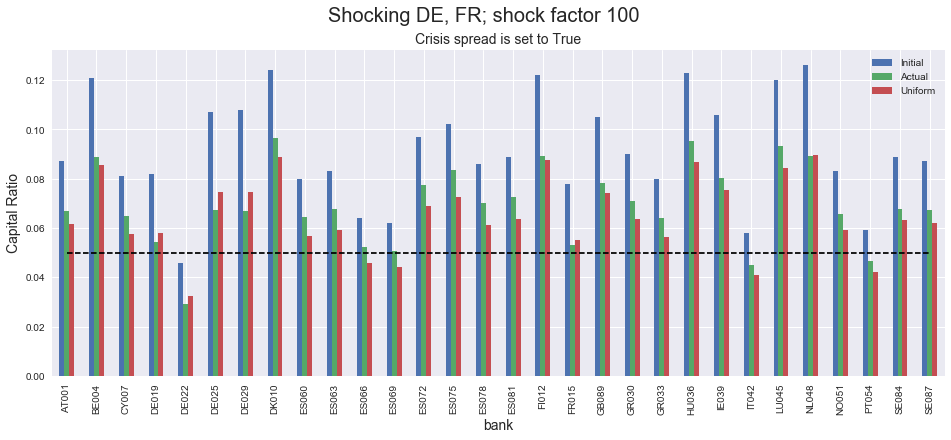

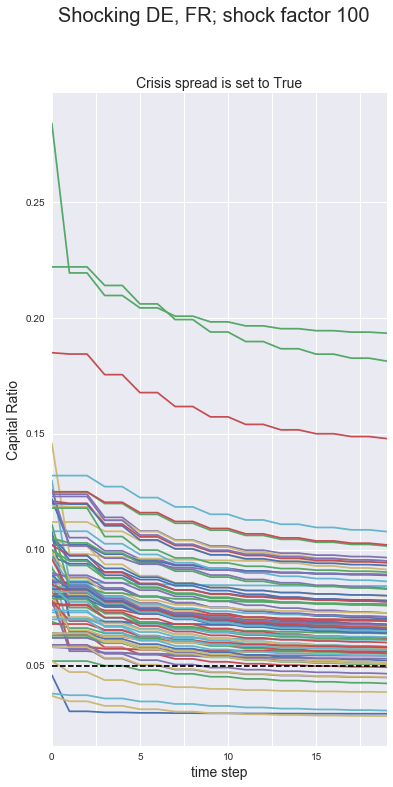

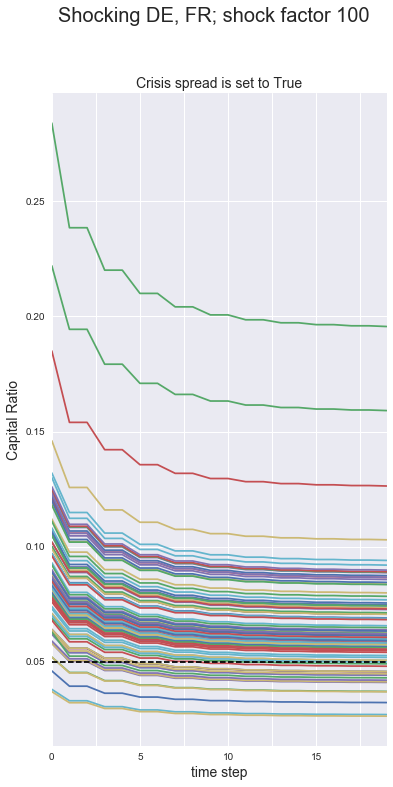

In [212]:
GenerateFigures(World(df), World(normalized_df), ["DE", "FR"], 100, True, 20)

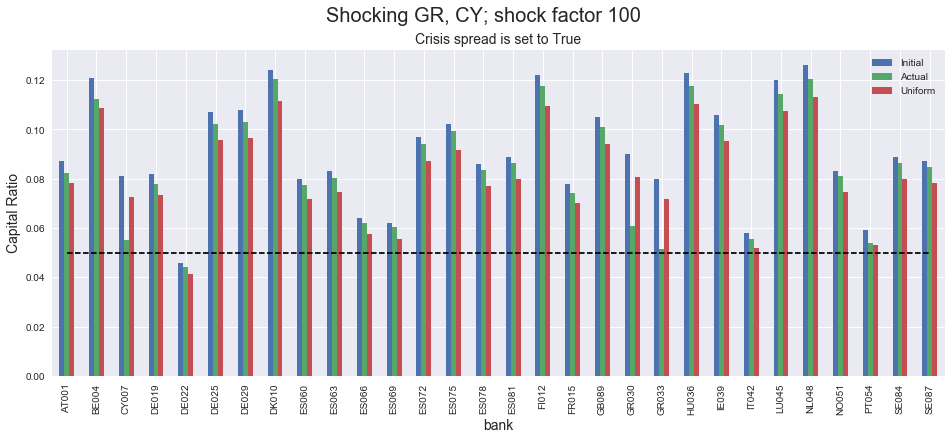

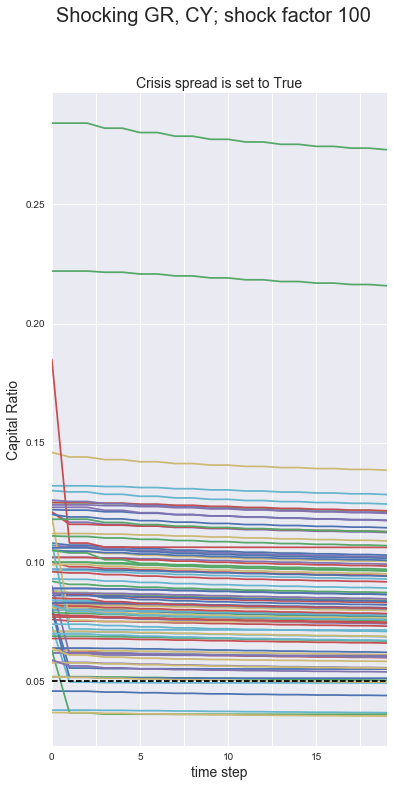

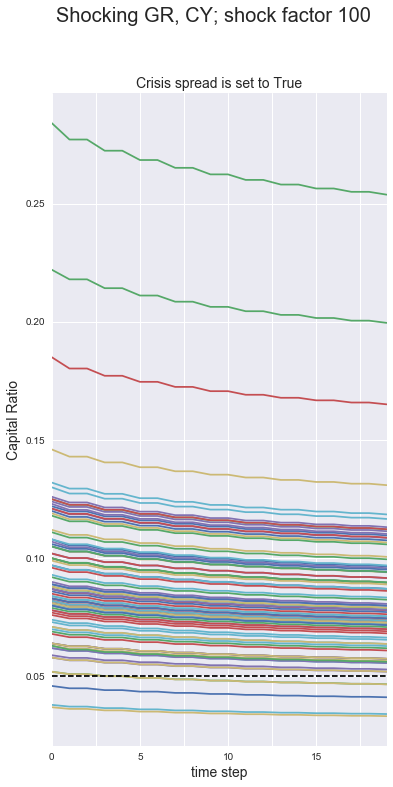

In [213]:
GenerateFigures(World(df), World(normalized_df), ["GR", "CY"], 100, True, 20)

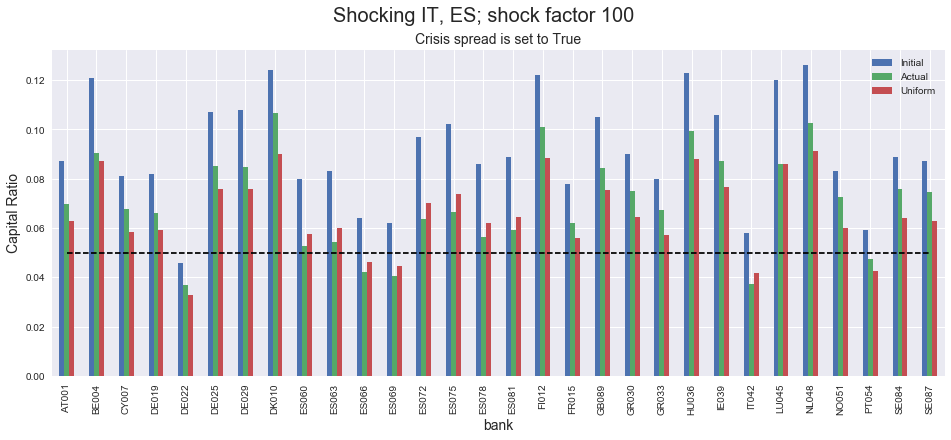

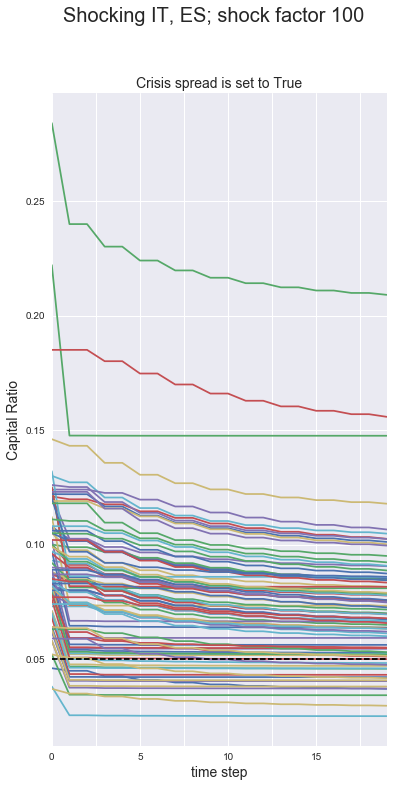

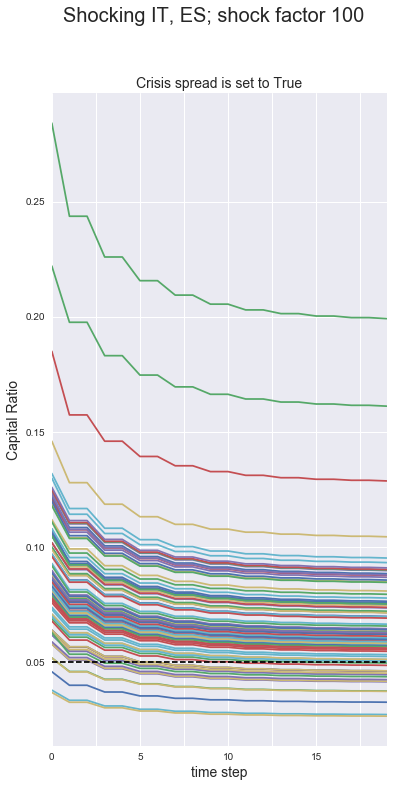

In [214]:
GenerateFigures(World(df), World(normalized_df), ["IT", "ES"], 100, True, 20)

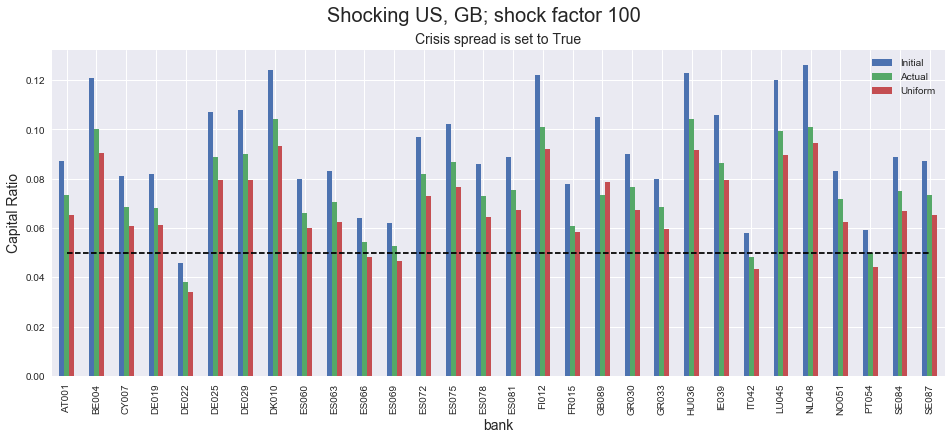

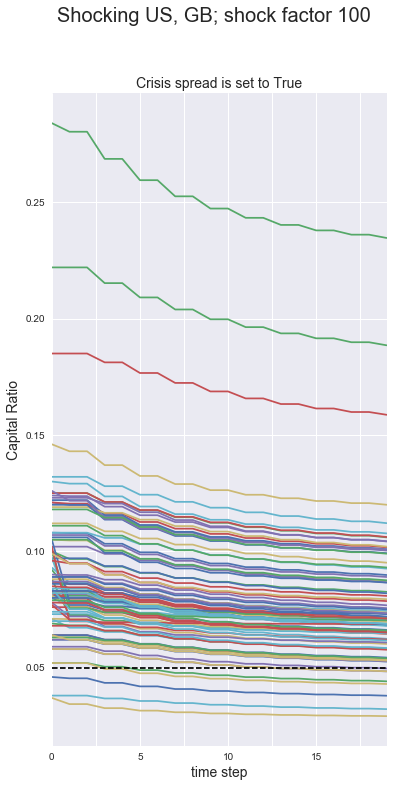

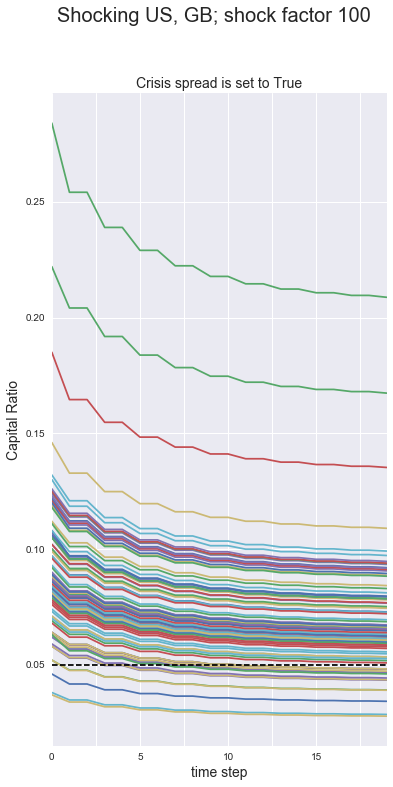

In [215]:
GenerateFigures(World(df), World(normalized_df), ["US", "GB"], 100, True, 20)